<span style="font-size: 28px; font-weight: bold">房产销售价中位数预测</span>

**本项目的任务：**
<p>你被老板协调到了机器学习小组，开始了你的第一个任务，每个街区的房产销售价中位数预测。你需要诸如每个街区组的人口数、收入中位数等指标进行预测。</p>
<p>首先，你得确定商业目标是什么？然后确定这是一个监督还是非监督问题；分类任务还是回归任务；批量学习还是在线学习？应该使用什么作为这个目标的性能指标？</p>
<p>好的，让我来回答这些问题。首先老板需要预测出一个街区的房价中位数，然后将他传递给另外一个系统。他们有一些专家进行估计的数据作为你可以使用的数据源，专家对街区房价中位数的预测正确率大概为85%。于是我们可以知道这是一个监督问题，属于回归任务，仅仅使用批量学习即可，因为没有特别的要求需要对数据的变动做出快速适应。</p>
<p>最后是一步是确认的性能指标。我们选择RMSE(均方根误差):</p>
$$RMSE(X, h) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)})^2}$$

**符号说明：**
<p>$m$ 是数据集中的实例数量</p>
<p>$x^{(i)}$ 是数据集第$i$个实例的所有特征值的向量，$y^{(i)}$是她的标签</p>

**练习：**
1. 尝试一个支持向量机回归器(`sklearn.svm.SVR`)，使用多个超参数。最佳的SCR预测表现如何？
2. 尝试用 `RandomizedSearchCV` 替换 `GridSearchSV`。
3. 尝试在准备流水线中添加一个只选择最重要属性的转换器。
4. 尝试创建一个单独的可以完成数据准备和最终预测的流水线。
5. 使用 `GridSearchCV` 自动探索一些准备过程中的候选项。

**现在就开始吧，祝我们有个好的结果。**

# 获取数据

In [19]:
import os
import tarfile
from six.moves import urllib

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
print('data is fetched at', HOUSING_PATH)

data is fetched at datasets/housing


# 探索数据

## 基本信息

In [4]:
housing = load_housing_data()
print('数据的规模:', housing.shape)
housing.head()

数据的规模: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<p>每一行都表示一个街区。共有*10*个属性：经度、维度、房屋年龄中位数、总房间数、总卧室数、人口数、家庭数、收入中位数、房屋价值中位数、离大海距离。</p>

<p>我们再来看一看每一列的属性</p>

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


可以看到有 *207* 个街区， *total_bedroom* 有缺失值。*ocean_proximity* 是非数字类型，而且他是有重复的，很可能是一项表示类别的属性。我们可以看看每个街区有多少条记录

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

我们还可以看看每个属性数据的概括

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


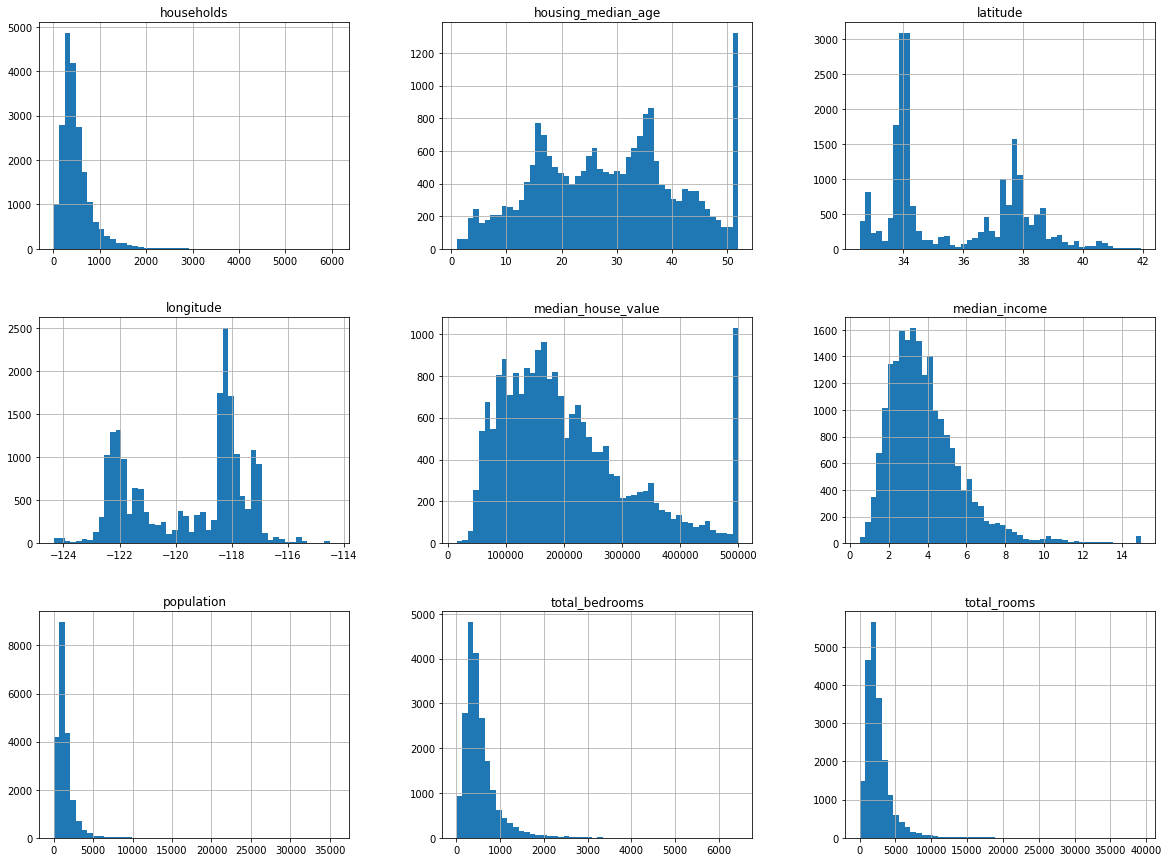

In [8]:
_subplots = housing.hist(bins=50, figsize=(20, 15))

可以发现：
1. *housing_median_age* 和 *median_house_value* 的中位数被设置了上限；
2. *median_income* 可能不是美元，并且被设置了上限；
3. 这些属性有不同的量度；
4. 很多属性中位数尾巴较长。

## 数据分割

*为什么要在探索数据之前分割数据？而不是在建立模型的时候*
<p>要回答这个问题，我们就要清楚机器学习中，训练集、验证集、测试集各有什么作用。</p>
<p>一般来说，我们不可以直接用所有的数据进行训练，因为我们将不能知道模型在其他数据上的表现如何。为了能够对模型的泛化能力进行估计，常常，我们将数据分割为**训练集**和**测试集**。我们用训练集的数据进行训练，用测试集的数据进行评估。</p>
<p>但是，假如我们一直使用测试集进行模型调参，那么最终我们会将模型超参数调整到能够很好反应测试集数据的规律。这不是我们想要的，因为这将不能保证对生产环境中的数据进行反应的估计。**因此，我们始终都不能使用测试集进行调参。**</p>
<p>那么，我们有什么办法么？一种是将训练集再分割成训练集和验证集，使用验证集进行调参。另一种就是使用交叉验证。</p>
<p>同样的，数据探索也会给我们一些数据规律的发现，这将导致我们的模型设计很可能对测试集产生过拟合。**因此，我们要在探索数据之前，就进行数据分割。**</p>

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

**采样偏差风险**
- <p>数据集很大时，可以随机采样；</p>
- <p>数据集不大时，随机采样会发生采样偏差风险。</p>

<p>比如某城市男女比例为60: 40。所以严谨的调查采样也应该满足这个比例。</p>
<p>而假如专家告诉你(后面我们会从让模型告诉你什么属性会更加重要)，收入中位数是预测房价中位数非常重要的属性，那么我们为了保证测试集中也有多种收入分类，因此，我们需要依靠收入采用分层抽样。</p>
<p>通过上面的 `describe` 我们可以看到收入分布聚集在2-5(万美元)，但是最大的收入超过了5(达到了13)。而数据集中每个分层都应该有足够的数据，这意味着，我们不能有过多的分层，且每个分层要足够大。</p>
<p>*为什么要除以1.5*</p>

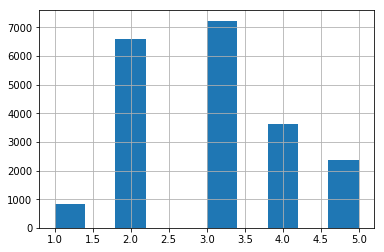

In [10]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
_data_plot = housing["income_cat"].hist()

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
print("train test 分割")
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print("删除分层采样的列")
for data_set in (strat_train_set, strat_test_set):
    data_set.drop(["income_cat"], axis=1, inplace=True)
print("train set shape:", strat_train_set.shape)
print("test set shape:", strat_test_set.shape)

train test 分割
删除分层采样的列
train set shape: (16512, 10)
test set shape: (4128, 10)


**现在开始，不要再看我们的测试集了！**

## 数据探索

为了避免探索损伤我们的训练集，我们需要拷贝一份。

In [12]:
housing_explore = strat_train_set.copy()

### 地理数据可视化

因为存在经度和维度，因此创建所有街区的散点图，是个不错的主意

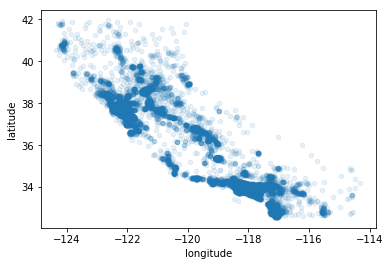

In [13]:
_map_plot = housing_explore.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

<p>如果你的地理不错，你可能看得出他很像加州。不过这样仅仅能看出街区的密集程度。</p>
<p>接下来，我们来看看地理位置和房价的关系。</p>

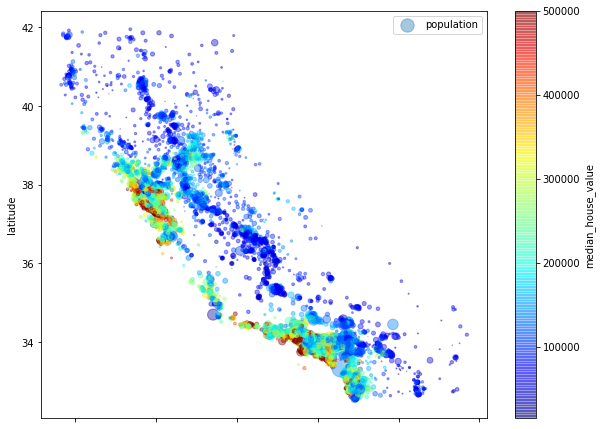

In [14]:
housing_explore.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(10, 7.5),
                    s=housing_explore["population"] / 100, label="population",
                    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
_legend = plt.legend()

<p>从图中可以看出，是否沿海、人口密集程度都是与房屋价格有关的属性。</p>
<p>因为我们可以生成新的属性(沿海距离等)，从而可以获取更多的特征。</p>

### 查找关联

#### 皮尔逊相关系数

In [15]:
corr_matrix = housing_explore.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

**注：相关系数只测量线性关系。**
<div style="margin-right: 30%;"><img src="images/2-14-different-val.png"/></div>
<p>不同数据集的标准相关系数(来源：Wikipedia：公共领域图片)</p>

#### 图表

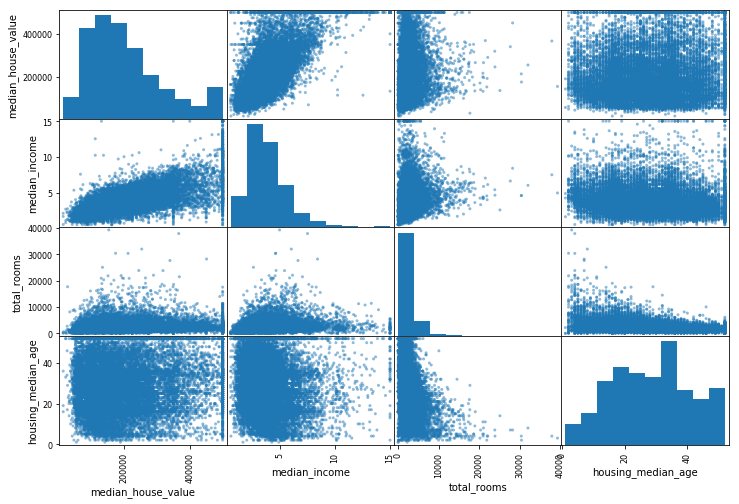

In [21]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
_corr_plots = scatter_matrix(housing_explore[attributes], figsize=(12, 8))

**在 *median_house_value* 和 *median_income* 的图表中，我们可以看出：**
- *median_house_value* 和 *median_income* 线性相关，并且相关性非常高(向上)；
- 注意图表中的横线，应该需要有某种方式将他们去掉？让算法避免这种巧合。

## 属性组合实验

尝试多种属性组合

In [23]:
housing_explore["rooms_per_household"] = housing_explore["total_rooms"] / housing_explore["households"]
housing_explore["bedrooms_per_room"] = housing_explore["total_bedrooms"] / housing_explore["total_rooms"]
housing_explore["population_per_household"] = housing_explore["population"] / housing_explore["households"]

现在再来查看相关矩阵

In [24]:
corr_matrix = housing_explore.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

会发现新的属性 *rooms_per_household* 比以前的 *total_rooms* 相关性更强

In [34]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        return np.c_[X, rooms_per_household, population_per_household]
    

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values

# 为机器学习算法准备数据

我们移除标签列 *median_house_value* 生成数据集，不用担心，这会生成一个新的副本集，而不会影响原来的数据。

In [26]:
housing_data = strat_train_set.drop(["median_house_value"], axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## 数据清洗

### 缺失值处理

- 去掉对应行；
- 去掉整列；
- 进行赋值(0，平均值，中位数等)。

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from utils.preprocessing import CategoricalEncoder

我们应该逐渐扩展我们的转换器，这样数据准备步骤越自动化，我们便能越容易发现更好的组合。

## 特征缩放

### 线性函数归一化(normalization)

值被转变、重新缩放，直到范围变成0到1。

### 标准化(standardization)

<p>首先减去平均值(所以标准化的平均值总为0)，然后除以方差，使得到的分布具有标准方差。</p>
<p>标准化不会限定值到特定的范围，但是他受异常值的影响很小。</p>

**与所有的转换一样，这些转换器只能对训练集拟合。**

## 转换流水线

In [344]:
cat_attribs = ["ocean_proximity"]
num_attribs = list(set(housing_data) - set(cat_attribs))
print("categorical attributes:", ', '.join(cat_attribs))
print("numberical attributes:", ', '.join(num_attribs))
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('categorical_encoder', CategoricalEncoder(encoding='onehot-dense'))
])
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

categorical attributes: ocean_proximity
numberical attributes: median_income, population, longitude, latitude, housing_median_age, total_bedrooms, total_rooms, households


In [346]:
housing_prepared = full_pipeline.fit_transform(housing_data)
print('housing prepared shape:', housing_prepared.shape)
housing_prepared[0, :]

housing prepared shape: (16512, 16)


array([-0.61493744, -0.63621141, -1.15604281,  0.77194962,  0.74333089,
       -0.44543821, -0.49323393, -0.42069842, -0.0424172 ,  0.15531753,
        0.59859578,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

# 选择并训练模型

## 在训练集上训练和评估

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [42]:
lr = LinearRegression()
lr.fit(housing_prepared, housing_labels)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
some_data = housing_data.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lr.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [208022.3684231  319465.39983778 212759.88714733  58777.46608227
 186054.70695627]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


还凑合，但是第二个预测偏离了50%

In [51]:
housing_predictions = lr.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("MSE:\t", lin_mse)
print("RMSE:\t", lin_rmse)

MSE:	 4732262651.752015
RMSE:	 68791.44315793946


In [53]:
dtr = DecisionTreeRegressor()
dtr.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [55]:
housing_predictions = dtr.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("MSE:\t", tree_mse)
print("RMSE:\t", tree_rmse)

MSE:	 0.0
RMSE:	 0.0


可以看到发生了严重的过拟合，因此下一节，我们需要使用验证集或者使用交叉验证做更佳的评估

## 使用交叉验证做更佳的评估

1. 将数据分割为训练集和验证集；
2. 使用交叉验证。

In [60]:
scores = cross_val_score(dtr, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [62]:
display_scores(rmse_scores)

Scores: [68847.6125822  65364.44589905 70557.63327063 69538.27442211
 69990.03979617 71411.25581178 71769.03941938 71422.9405648
 71730.57774625 70910.26630807]
Mean: 70154.20858204455
Standard deviation: 1845.8653165182293


In [64]:
lin_scores = cross_val_score(lr, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66926.50425519 67173.33168778 70185.80472301 74757.59785208
 67705.8885363  71173.42499481 65194.53834348 68132.37832603
 71942.749221   67671.57008222]
Mean: 69086.37880218982
Standard deviation: 2723.5061982749726


<p>这时候就可以看到，决策树的结果比线性回归还要遭。</p>
<p>下面，我们使用集成模型 `RandomForestRegressor` 来试试。</p>

In [66]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_reg_score = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                                   scoring='neg_mean_squared_error', cv=10)
forest_reg_rmse = np.sqrt(-forest_reg_score)
display_scores(forest_reg_rmse)

Scores: [51271.02683165 51224.46346309 53177.79420586 54895.89620928
 52280.79920356 55584.41874791 50965.71026305 54030.05235425
 54048.27868004 52111.31439764]
Mean: 52958.97543563411
Standard deviation: 1550.340098343904


<p>模型的表现还不错，有希望。</p>
<p>但是算法还是过拟合了。接下来的优化：</p>

- 给模型加限制；
- 用更多的训练数据。

<p>尝试下别的模型很有必要。</p>

## 选择微调

### 网格搜索

In [103]:
from sklearn.model_selection import GridSearchCV

In [339]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

**一个搜寻的建议是：尝试连续的10(或者更小的数)的幂来搜索超参数**

我们还可以找到所有的搜寻结果：

In [340]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

66199.07449908202 {'max_features': 2, 'n_estimators': 3}
58239.27128854379 {'max_features': 2, 'n_estimators': 10}
54625.783024964985 {'max_features': 2, 'n_estimators': 30}
62346.414700392554 {'max_features': 4, 'n_estimators': 3}
54524.61034113836 {'max_features': 4, 'n_estimators': 10}
51785.341976646545 {'max_features': 4, 'n_estimators': 30}
61673.103356764506 {'max_features': 6, 'n_estimators': 3}
53781.20447700291 {'max_features': 6, 'n_estimators': 10}
51620.01196305622 {'max_features': 6, 'n_estimators': 30}
59891.30060914522 {'max_features': 8, 'n_estimators': 3}
53150.76576766365 {'max_features': 8, 'n_estimators': 10}
51169.85121963611 {'max_features': 8, 'n_estimators': 30}
64821.3103282842 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56421.21988941994 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
62153.248182512216 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
54690.81483284156 {'bootstrap': False, 'max_features': 3, 'n_estimators'

>提示：不要忘记，你可以像超参数一样处理数据准备的步骤。例如，网格搜索可以自动判断是否添加一个你不确定的特征（比如，使用转换器 `CombinedAttributesAdder` 的超参数 `add_bedrooms_per_room`）。它还能用相似的方法来自动找到处理异常值、缺失特征、特征选择等任务的最佳方法。

### 随机搜索

当超参数的搜索空间很大的时候，我们最好使用 `RandomizedSearchCV` 。这种方法有两个优点：
1. 让随机搜索运行。
2. 方便的通过设定搜索次数，控制超参数搜索的计算量。

### 集成方法

之后会提到

### 分析最佳模型和它们的误差

属性对预测的相对重要性：

In [341]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [342]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_hhold"]
cat_one_hot_attribs = list(cat_pipeline.named_steps['categorical_encoder'].categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.37545230888901043, 'median_income'),
 (0.15959312668585018, 'INLAND'),
 (0.09629448137712551, 'longitude'),
 (0.08873720983685268, 'pop_per_hhold'),
 (0.08405483264948248, 'latitude'),
 (0.04108182176940129, 'bedrooms_per_hhold'),
 (0.031337337799777036, 'population'),
 (0.029202686575821552, 'housing_median_age'),
 (0.020751912297429145, 'total_bedrooms'),
 (0.019313145574314548, 'total_rooms'),
 (0.019246033542769818, 'rooms_per_hhold'),
 (0.019245607290496392, 'households'),
 (0.008548696839181243, '<1H OCEAN'),
 (0.0057047022742860365, 'NEAR OCEAN'),
 (0.0014263767116616016, 'NEAR BAY'),
 (9.719886539953199e-06, 'ISLAND')]

于是我们可以丢弃一些不重要的特征

另外，我们还应该看一下系统犯的误差，搞清楚：
1. 为什么会有些误差；
2. 如何改成；(添加更多的特征，或，去掉没有什么信息的特征，清洗异常值等)。

## 用测试集评估系统

调节完系统后，终于有了一个性能足够好的系统。现在可以用测试集评估最后的模型了。

In [347]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"]

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_cross_scores = cross_val_score(final_model, housing_prepared, housing_labels, 
                                     scoring='neg_mean_squared_error', cv=10)
final_cross_rmse = np.average(np.sqrt(-final_cross_scores))
print("CROSS-VALIDATE-SET RMSE:", final_cross_rmse)
print("TEST SET RMSE:", final_rmse)

CROSS-VALIDATE-SET RMSE: 50576.65198380365
TEST SET RMSE: 48611.37079131345


一般来说，测试集的评估结果要比交叉验证的差一些。如果发生了这种情况，一定要<span style="font-size: 18px;">**忍住不要去调节超参数**</span>，这样的提升不能推广到新数据上。

接下来，就是项目预上线阶段：
1. 展示你的方案：
    - 学到了什么
    - 做了什么
    - 没做什么
    - 做过什么假设
    - 系统的限制是什么等
2. 记录下所有事情
3. 漂亮的图表和容易记住的表达

# 启动、监控、维护系统

1. 为实际生产做好准备：接入输入数据源，编写测试等
2. 编写监控代码，固定的间隔检测系统的实时表现，当发生下降时报警(防止系统崩溃、性能下降)
3. 评估系统的表现需要对预测值采样并进行评估。(人工评估的流水线植入系统)
4. 评估系统输入数据的质量。(传感器失灵、另一个团队输出停滞等)系统的表现下降需要一定的时间，这样就能早发现问题
5. 你可能想定期用新数据训练模型，你应该尽可能自动化这个过程。如果是线上学习系统，那么就需要保存好系统状态快照，方便回滚到之前的工作状态。

# 问题

## 长尾分布为什么需要转换？

In [216]:
from scipy.stats import boxcox

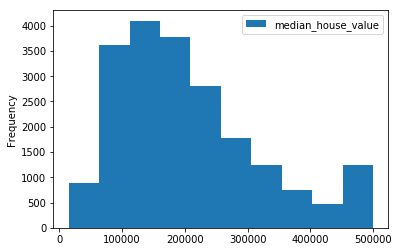

In [224]:
housing.plot(x='households', y='median_house_value', kind='hist')

In [326]:
class NormalDistributeTransformer(BaseEstimator, TransformerMixin):
    """将数据转换成正态分布的转换器"""
    
    def __init__(self, method='boxcox', epsilon=0.000001):
        self._method = method
        self._epsilon = epsilon
        self._max_log = []
        self._fit_func = None
        self._transform_func = None
        self._pre_settings(method)

    def _pre_settings(self, method):
        self._fit_func = getattr(self, '_fit_%s' % method, None)
        self._transform_func = getattr(self, '_transform_%s' % method, None)
        if self._fit_func is None or self._transform_func is None:
            raise ValueError("method must be boxcox or log")
    
    def _fit_boxcox(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        _transform_X = []
        for ind in range(X.shape[1]):
            __transform_X, max_log = boxcox(X[:, ind].reshape(-1, 1))
            _transform_X.append(__transform_X)
            self._max_log.append(max_log)
        _transform_X = np.concatenate(_transform_X, axis=1)
        return _transform_X
    
    def _fit_log(self, X, y=None):
        return self
    
    def _transform_boxcox(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        _transform_X = []
        for ind in range(X.shape[1]):
            _transform_X.append(boxcox(X[:, ind].reshape(-1, 1), lmbda=self._max_log[ind]))
        _transform_X = np.concatenate(_transform_X, axis=1)
        return _transform_X
    
    def _transform_log(self, X, y=None):
        return np.log(X + self._epsilon)

    def fit(self, X, y=None):
        self._fit_func(X, y)
        return self

    def transform(self, X, y=None):
        return self._transform_func(X, y)

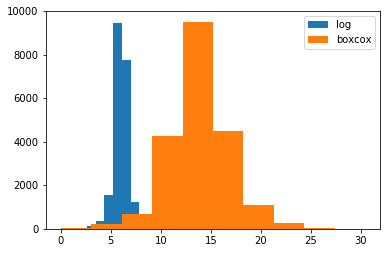

In [327]:
boxcox_transformer = NormalDistributeTransformer(method='boxcox')
log_transformer = NormalDistributeTransformer(method='log')
households = boxcox_transformer.fit_transform(housing['households'].values)
log_households = log_transformer.fit_transform(housing['households'].values)
plt.hist(log_households, label='log')
plt.hist(households, label='boxcox')
plt.legend()

# 练习

In [208]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

尝试SVR和他的一些参数

In [112]:
svr = SVR(kernel='poly')
svr.fit(housing_prepared, housing_labels)
svr_mse = mean_squared_error(housing_labels, svr.predict(housing_prepared))
svr_rmse = np.sqrt(svr_mse)
print("SVR RMSE:", svr_rmse)

SVR RMSE: 118692.37684590863


使用 `RandomizedSearchCV` 代替 `GridSearchCV`

注意：`RandomizedSearchCV` 参数字典的value，可以是一个列表，也可以是一个分布。可以使用 `n_iter` 控制最大尝试次数。

In [210]:
svr_random_params = {'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1, 10, 100]}
estimator = SVR()
random_cv = RandomizedSearchCV(estimator, svr_random_params, 
                               scoring='neg_mean_squared_error', cv=5, n_jobs=-1, n_iter=4)
random_cv.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=4, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [211]:
np.sqrt(-random_cv.best_score_)

98750.16769660922

一个最重要的特征的选择器

In [133]:
class ImportantFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1):
        self.n_features = n_features
        self._estimator = None
    
    def fit(self, X, y=None):
        _estimator = DecisionTreeRegressor()
        _estimator.fit(X, y)
        self._estimator = _estimator
        return self
    
    def transform(self, X, y=False):
        if self._estimator is None:
            raise RuntimeError("you must run `fit` function first")
        feature_importances = self._estimator.feature_importances_
        feature_index = np.argsort(feature_importances)[-self.n_features:]
        return X[:, feature_index]

In [134]:
important_feature_selector = ImportantFeatureSelector()
important_feature_selector.fit(housing_prepared, housing_labels)
important_feature_selector.transform(housing_prepared).shape

(16512, 1)

尝试完成一个单独的可以完成数据准备和最终预测的流水线

In [163]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [334]:
digits_data = load_digits()
X, y = digits_data.data, digits_data.target
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(X, y, test_size=0.25, random_state=42)
print("Data-set shape:", X.shape)

Data-set shape: (1797, 64)


In [335]:
digits_data_pipeline = Pipeline([
    ("feature_selector", ImportantFeatureSelector(n_features=40)),
    ("scaler", StandardScaler()),
    ("predictor", SVC())
])

In [336]:
digits_data_pipeline.fit(X_train_digits, y_train_digits)

Pipeline(memory=None,
     steps=[('feature_selector', ImportantFeatureSelector(n_features=40)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [337]:
print("Score on train set:", digits_data_pipeline.score(X_train_digits, y_train_digits))
print("Score on test set:", digits_data_pipeline.score(X_test_digits, y_test_digits))

Score on train set: 0.9970304380103935
Score on test set: 0.9888888888888889


使用 `GridSearchCV` 自动探索一些准备过程中的候选项

In [214]:
digits_data_pipeline = Pipeline([
    ("feature_selector", ImportantFeatureSelector()),
    ("scaler", StandardScaler()),
    ("predictor", SVC())
])
grid_params = [{
    'feature_selector__n_features': [5, 10, 20, 40], 
    'predictor__kernel': ['rbf', 'linear'], 
    'predictor__C': [0.1, 1, 10]
}]
grid_search = GridSearchCV(digits_data_pipeline, grid_params, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_selector', ImportantFeatureSelector(n_features=1)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'feature_selector__n_features': [5, 10, 20, 40], 'predictor__kernel': ['rbf', 'linear'], 'predictor__C': [0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [215]:
grid_search.best_params_

{'feature_selector__n_features': 40,
 'predictor__C': 1,
 'predictor__kernel': 'rbf'}

**在使用 `GridSearchCV` 对 `pipeline` 中的超参数进行搜索时，可以使用其名称+__+参数名**

# 对数据进行长尾分布的转换后...

之前最好的结果是(在测试集上)：
$$RMSE = 48832.93386503177$$
让我们转换后，再次查看结果

在我们的 `pipeline` 中添加正态分布转换器

In [363]:
cat_attribs = ["ocean_proximity"]
num_attribs = list(set(housing_data) - set(cat_attribs))
normal_attribs = ['households', 'population', 'total_bedrooms', 'total_rooms']
print("categorical attributes:", ', '.join(cat_attribs))
print("numberical attributes:", ', '.join(num_attribs))
print("normal attributes:", ', '.join(normal_attribs))
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
normal_pipeline = Pipeline([
    ('selector', DataFrameSelector(normal_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('normal_transformer', NormalDistributeTransformer()),
    ('std_scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('categorical_encoder', CategoricalEncoder(encoding='onehot-dense'))
])
full_pipeline_normal = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('normal_pipeline', normal_pipeline),
    ('cat_pipeline', cat_pipeline)
])

categorical attributes: ocean_proximity
numberical attributes: median_income, population, longitude, latitude, housing_median_age, total_bedrooms, total_rooms, households
normal attributes: households, population, total_bedrooms, total_rooms


In [364]:
housing_prepared_normal = full_pipeline_normal.fit_transform(housing_data)
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search_normal = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_normal.fit(housing_prepared_normal, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [367]:
print("RMSE with no transform(train):", final_cross_rmse)
print("RMSE with no transform(test):", final_rmse)
best_model = grid_search_normal.best_estimator_
housing_prepared_test_normal = full_pipeline_normal.transform(X_test)
housing_prediction_normal = best_model.predict(housing_prepared_test_normal)
normal_rmse = np.sqrt(mean_squared_error(y_test, housing_prediction_normal))
normal_cross_scores = cross_val_score(best_model, housing_prepared_test_normal, y_test, 
                                      scoring='neg_mean_squared_error', cv=10)
normal_cross_rmse = np.average(np.sqrt(-normal_cross_scores))

print("RMSE with normal transform(train):", normal_cross_rmse)
print("RMSE with normal transform(test):", normal_rmse)

RMSE with no transform(train): 50576.65198380365
RMSE with no transform(test): 48611.37079131345
RMSE with normal transform(train): 54906.77138588391
RMSE with normal transform(test): 48171.38837565678
